In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import datetime
import random
import tensorflow as tf
import keras
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator ## Reference - https://keras.io/preprocessing/image/

Using TensorFlow backend.


In [11]:
path = "C:/Users/User/Project---Real-Time-Hand-Gesture-Detection/Dataset/"
Model = "C:/Users/User/Project---Real-Time-Hand-Gesture-Detection/Model/"

In [3]:
## Creating Folder to Store Images
os.mkdir(os.path.join(path, "train"))
os.mkdir(os.path.join(path, "test"))
os.mkdir(os.path.join(path, "captured_for_train"))
os.mkdir(os.path.join(path, "captured_for_test"))
for i in range(26):
    label = chr(ord('A') + i)
    os.mkdir(os.path.join(path + "train", label))
    os.mkdir(os.path.join(path + "test", label))
    os.mkdir(os.path.join(path + "captured_for_train", label))
    os.mkdir(os.path.join(path + "captured_for_test", label))

## 1) Collect Dataset

In [4]:
## Display SideBar
def sidebar(dict, frame):
    for i in range(26):
        label = chr(ord('A') + i)
        cv2.putText(frame, label + " :: " + str(dict[label]), (10, 10 + i * 15), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)

In [5]:
## Count of Images Present in the Folder
def Count(directory):
    dict = {}
    for i in range(26):
        label = chr(ord('A') + i)
        dict[label] = len(os.listdir(path + directory + "/" + label))
    return dict

In [6]:
## Original Image ==> Gray Scale Image ==> Apply Gaussian Blur Filter
def get_Filtered_Image(frame, size_of_frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 2)
#     cv2.imshow("After applying Gaussian Blur", blur)
    minValue = 70
    th = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    ret, output = cv2.threshold(th, minValue, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    output = cv2.resize(output, (size_of_frame, size_of_frame))
    return output

In [7]:
## Collecting Images ........
def COLLECT_IMAGES(directory):
    cap = cv2.VideoCapture(0)
    max_frame_to_be_printed = 3
    while(1):
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)

        ## Displaying SideBar
        cnt = Count(directory)
        sidebar(cnt, frame)

        ## ROI
        x1 = int(0.5 * frame.shape[1])
        y1 = 10
        x2 = frame.shape[1] - 10
        y2 = int(0.5 * frame.shape[1])
        cv2.rectangle(frame, (220 - 1, 9), (620 + 1, 419), (255, 255, 255), 1)
        ROI = frame[10:410, 220:520]

        ## Original Image ==> Gray Scale Image ==> Apply Gaussian Blur Filter
        output = get_Filtered_Image(ROI, 300)
        cv2.imshow("ROI", output)
        cv2.imshow("Original", frame)

        ## Interrupt Handling
        interrupt = cv2.waitKey(1)
        if(interrupt == 27): ## Esc to close the WebCam
            break
        if(interrupt > 123 or interrupt < 97): ## Ignoring All other interrupt
            continue
        label = chr(interrupt - 97 + ord('A'))
        imgName = path + directory + "/" + label + "/" + str(cnt[label]) + ".jpg"
        status = cv2.imwrite(imgName, ROI)
        if(max_frame_to_be_printed > 0):
            plt.imshow(frame)
            plt.title("User Showing Alphabet " + label)
            plt.show()
            max_frame_to_be_printed -= 1

    cv2.destroyAllWindows()
    cap.release()

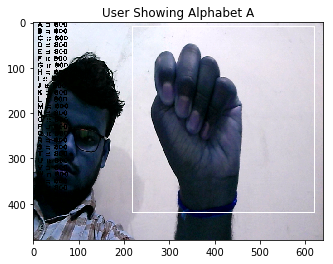

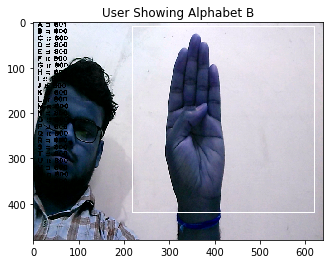

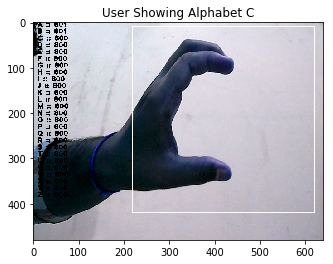

26
{'A': 801, 'B': 801, 'C': 801, 'D': 800, 'E': 800, 'F': 800, 'G': 800, 'H': 800, 'I': 800, 'J': 800, 'K': 800, 'L': 800, 'M': 800, 'N': 800, 'O': 800, 'P': 800, 'Q': 800, 'R': 800, 'S': 800, 'T': 800, 'U': 800, 'V': 800, 'W': 800, 'X': 800, 'Y': 800, 'Z': 800}


In [5]:
## Uncomment when you have o collect data for training
COLLECT_IMAGES("captured_for_train")
cnt = Count("captured_for_train")
print(len(cnt))
print(cnt)

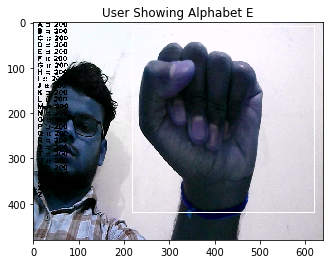

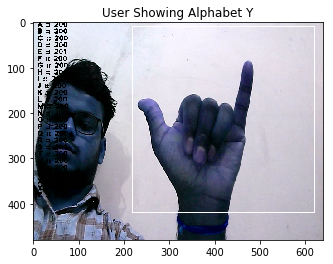

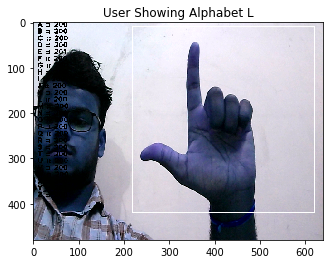

26
{'A': 200, 'B': 200, 'C': 200, 'D': 200, 'E': 201, 'F': 200, 'G': 200, 'H': 200, 'I': 200, 'J': 200, 'K': 200, 'L': 201, 'M': 200, 'N': 200, 'O': 200, 'P': 200, 'Q': 200, 'R': 200, 'S': 200, 'T': 200, 'U': 200, 'V': 200, 'W': 200, 'X': 200, 'Y': 201, 'Z': 200}


In [6]:
## Uncomment when you have o collect data for testing
COLLECT_IMAGES("captured_for_test")
cnt = Count("captured_for_test")
print(len(cnt))
print(cnt)

## 2) PreProcessing 

In [8]:
size_of_image = 126

In [9]:
## Splitting into 80-20 % (80% training, 20% testing)
def preprocess(from_directory, to_directory, iss = False):
    cnt = 0
    for i in range(26):
        label = chr(ord('A') + i)
        directory = path + from_directory + "/" + label
        for _, _, folder in os.walk(directory):
            Len = len(folder)
            idx = [j for j in range(Len)]
            random.shuffle(idx)
            for j in range(Len):
                cnt += 1
                if(iss == False):
                    continue
                imgName = str(idx[j]) + ".jpg"
                imgPath = directory + "/" + imgName
                img = cv2.imread(imgPath);
                img = get_Filtered_Image(img, size_of_image)
                newPath = path + to_directory + "/" + label + "/" + imgName
                cv2.imwrite(newPath, img)
                
    return cnt

In [12]:
## Pass, is = True, when you need preprocessing
num_of_training_images = preprocess("captured_for_train", "train")
num_of_testing_images = preprocess("captured_for_test", "test")
print("number of images in training set :: ", num_of_training_images)
print("number of images in testing set :: ", num_of_testing_images)

number of images in training set ::  20800
number of images in testing set ::  5200


## 3) Visualizing Dataset

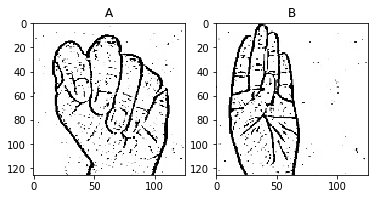

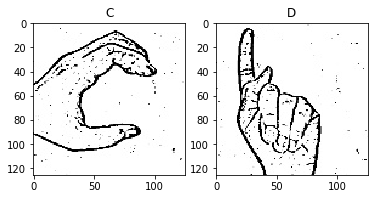

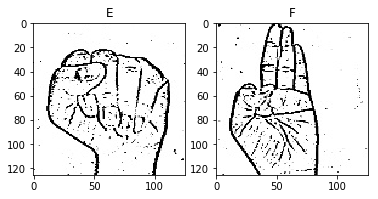

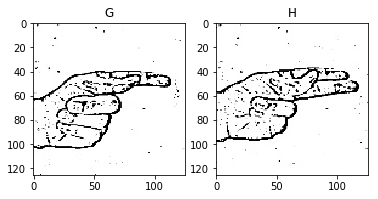

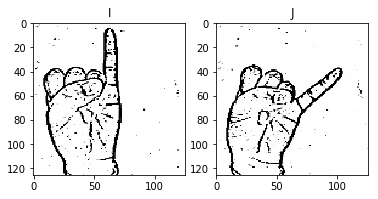

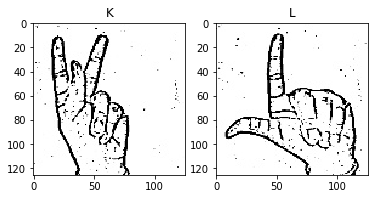

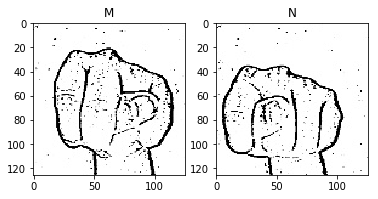

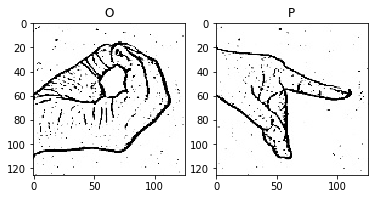

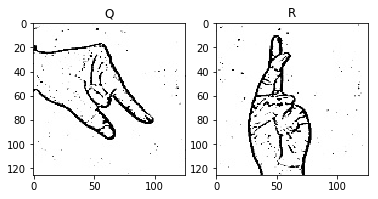

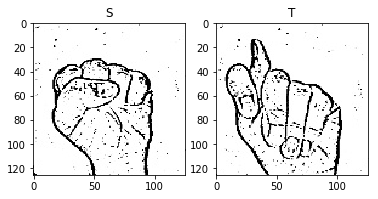

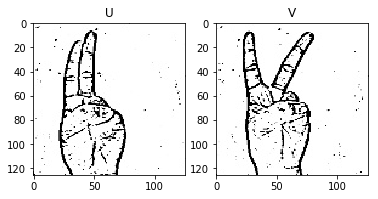

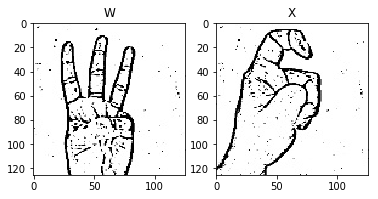

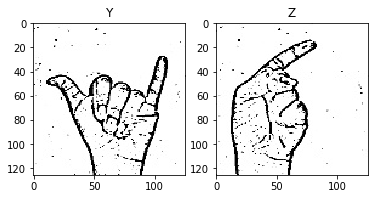

In [13]:
temp = []
for i in range(26):
    label = chr(ord('A') + i)
    directory = path + "test" + "/" + label
    for _, _, folder in os.walk(directory):
        temp.append(label + "/" + folder[0])
        
for i in range(26):
    if(i&1):
        continue
    imgPath = path + "test" + "/" + temp[i]
    label = chr(ord('A') + i)
    img = cv2.imread(imgPath)
    plt.subplot(1, 2, 1)
    img = cv2.resize(img, (size_of_image, size_of_image))
    plt.imshow(img, cmap = "gray")
    plt.title(label)

    imgPath = path + "test" + "/" + temp[i + 1]
    label = chr(ord('A') + i + 1)
    img = cv2.imread(imgPath)
    plt.subplot(1, 2, 2)
    img = cv2.resize(img, (size_of_image, size_of_image))
    plt.imshow(img, cmap = "gray")
    plt.title(label)
    plt.show()

## 4) Preparing Training & Testing Data

In [14]:
training_Dataset_Path = path + "train"
testing_Dataset_Path = path + "test"
training_BatchSize = 5
testing_BatchSize = 5

In [15]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_batches = train_datagen.flow_from_directory(training_Dataset_Path,
                                                 target_size = (size_of_image, size_of_image),
                                                 class_mode = "categorical",
                                                 color_mode="grayscale",
                                                 batch_size = training_BatchSize) 
test_batches = test_datagen.flow_from_directory(testing_Dataset_Path,
                                                 target_size = (size_of_image, size_of_image),
                                                 class_mode = "categorical",
                                                 color_mode="grayscale",
                                                 batch_size = testing_BatchSize)

Found 20800 images belonging to 26 classes.
Found 5200 images belonging to 26 classes.


In [16]:
print(train_batches.classes.shape)
train_batches.samples

(20800,)


20800

(126, 126, 1)
5


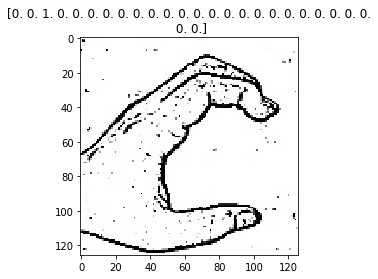

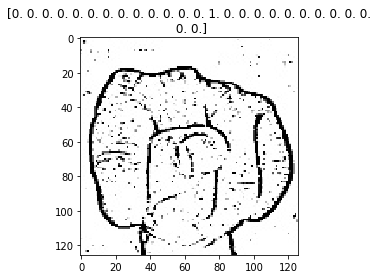

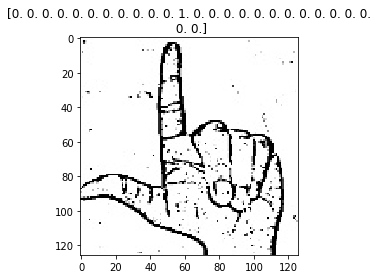

In [17]:
imgs, labels = next(train_batches)
print(imgs[0].shape)
print(len(imgs))
# print(labels)
cnt = 3
for img, label in zip(imgs, labels):
    img = cv2.resize(img, (size_of_image, size_of_image))
    plt.imshow(img, cmap = "gray")
    plt.title(label)
    plt.show()
    cnt -= 1
    if(cnt == 0):
        break

## 5) Building Convolution Neural Network Model 

In [18]:
## Initializing the CNN
classifier = Sequential()

## 1st CNN layer and pooling Layer
n_conv1 = 32
k_conv1 = 3
k_pol1 = 2
classifier.add(Conv2D(n_conv1, (k_conv1, k_conv1), input_shape = (size_of_image, size_of_image, 1), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (k_pol1, k_pol1)))

## 2nd CNN layer and pooling Layer
n_conv2 = 32
k_conv2 = 3
k_pol2 = 2
classifier.add(Conv2D(n_conv2, (k_conv2, k_conv2), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (k_pol2, k_pol2)))

## Flattening the layers
classifier.add(Flatten())

## Hidden/Dense Layer
classifier.add(Dense(units = 128, activation = 'relu'))
# classifier.add(Dense(units = 128, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.001)))
classifier.add(Dropout(0.30))
classifier.add(Dense(units = 96, activation = 'relu'))
# classifier.add(Dense(units = 96, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.001)))
classifier.add(Dropout(0.20))

classifier.add(Dense(units = 64, activation = 'relu'))
# classifier.add(Dense(units = 64, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.001)))

## Output Layer
classifier.add(Dense(units = 26, activation = 'softmax')) 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [19]:
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 124, 124, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3686528   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

## 6) Compliling our CNN Model

In [20]:
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

## 7) Training the Model

In [ ]:
# ## validation_steps = num_of_testing_images // testing_BatchSize
# ## steps_per_epoch = num_of_training_images // training_BatchSize
# history = classifier.fit_generator(
#                 train_batches,
#                 steps_per_epoch = num_of_training_images // training_BatchSize, 
#                 epochs = 20, ## try to change the value
#                 validation_data = test_batches,
#                 validation_steps = num_of_testing_images // testing_BatchSize) 

In [18]:
history = classifier.fit_generator(
                train_batches,
                steps_per_epoch = num_of_training_images, 
                epochs = 5, ## try to change the value
                validation_data = test_batches,
                validation_steps = num_of_testing_images) 


Epoch 1/5
20800/20800 [==============================] - 1804s 87ms/step - loss: 0.0967 - accuracy: 0.9709 - val_loss: 0.0063 - val_accuracy: 0.8304
Epoch 2/5
20800/20800 [==============================] - 1749s 84ms/step - loss: 0.0095 - accuracy: 0.9975 - val_loss: 1.2690 - val_accuracy: 0.8321
Epoch 3/5
20800/20800 [==============================] - 1784s 86ms/step - loss: 0.0070 - accuracy: 0.9985 - val_loss: 0.9081 - val_accuracy: 0.8417
Epoch 4/5
20800/20800 [==============================] - 1728s 83ms/step - loss: 0.0071 - accuracy: 0.9986 - val_loss: 3.0288 - val_accuracy: 0.8375
Epoch 5/5
20800/20800 [==============================] - 1795s 86ms/step - loss: 0.0054 - accuracy: 0.9991 - val_loss: 5.3034 - val_accuracy: 0.8385


## 8) Prediction on Random Images

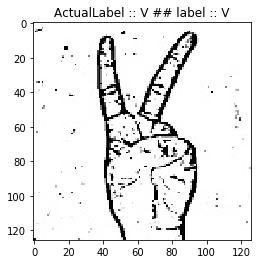

In [36]:
imgs, labels = next(test_batches)
img = cv2.resize(imgs[0], (size_of_image, size_of_image))
result = classifier.predict(img.reshape(1, size_of_image, size_of_image, 1))
# print(result)
# print(result.shape)
# print(labels[0])
# print(labels[0].shape)
idx = 0
pro = 0.0
idxActual = 0
proActual = 0.0
for i in range(26):
    if(pro < result[0][i]):
        pro = result[0][i]
        idx = i
    if(proActual < labels[0][i]):
        proActual = labels[0][i]
        idxActual = i
        
label = chr(ord('A') + idx)
ActualLabel = chr(ord('A') + idxActual)

plt.imshow(img, cmap = "gray")
plt.title("ActualLabel :: " + ActualLabel + " ## label :: " + label)
plt.show()

## 9) Accuracy, Confution Matrix & Classification Report  of our Model

In [37]:
## Loss Value, Accuracy
test_score = classifier.evaluate(test_batches)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

1040/1040 [==============================] - 11s 11ms/step
[INFO] accuracy: 83.85%
[INFO] Loss:  0.030070578679442406


Text(0.5,1,'Loss Curves')

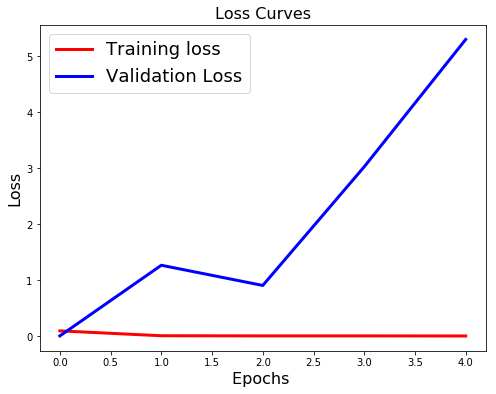

In [38]:
## Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

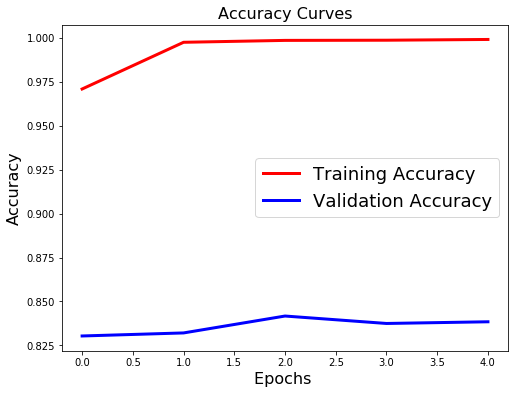

In [39]:
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [40]:
## Prediction on Testing data
y_pred = []
for i in range(26):
    label = chr(ord('A') + i)
    directory = path + "test" + "/" + label
    for _, _, folder in os.walk(directory):
        for imgName in folder:
            imgName = directory + "/" + imgName
            img = cv2.imread(imgName)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (size_of_image, size_of_image))
            img = img.reshape(1, size_of_image, size_of_image, 1)
            result = classifier.predict(img)
            idx = 0
            probability = 0.0
            for i in range(26):
                if(probability < result[0][i]):
                    probability = result[0][i]
                    idx = i
            y_pred.append(idx)

In [41]:
## Confusion Matrix 
print("================")
print('Confusion Matrix')
print("================")
print(confusion_matrix(test_batches.classes, y_pred))

Confusion Matrix
[[162   0   0   0   0   0   0   0   0   0  19   0   6   0   9   0   0   0
    0   4   0   0   0   0   0   0]
 [  0 148   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0  51   0   0   0   0   0]
 [  0   0 194   0   3   0   0   0   0   0   0   0   0   0   3   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0 200   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0 200   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 189   0   0  11   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 190   5   0   1   0   0   0   0   4   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 101  95   0   1   0   0   0   0   3   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   9   0   0 189   0   0   0   0   0   0   0   2   0
    0   0   0   0   0   0   0   0]
 [

In [42]:
## Classification Report
print("=====================")
print('Classification Report')
print("=====================")
target_names = [chr(ord('A') + i) for i in range(26)]
print(classification_report(test_batches.classes, y_pred, target_names = target_names))

Classification Report
              precision    recall  f1-score   support

           A       0.79      0.81      0.80       200
           B       0.99      0.74      0.85       200
           C       1.00      0.97      0.98       200
           D       0.78      1.00      0.88       200
           E       0.98      1.00      0.99       200
           F       0.95      0.94      0.95       200
           G       0.65      0.95      0.77       200
           H       0.92      0.47      0.63       200
           I       0.91      0.94      0.93       200
           J       0.96      1.00      0.98       200
           K       0.79      1.00      0.88       200
           L       1.00      0.91      0.95       200
           M       0.66      1.00      0.80       200
           N       1.00      0.67      0.80       200
           O       0.75      0.47      0.57       200
           P       0.90      0.97      0.94       200
           Q       0.92      0.70      0.79       200
     

## 10) Saving Model to JSON File

In [43]:
# model_json = classifier.to_json()
# with open(Model + "final_model.json", "w") as json_file:
#     json_file.write(model_json)
# print('========Model Saved==========')
# classifier.save_weights(Model + "final_weights.h5")
# print('========Weights Saved========')

========Model Saved==========
========Weights Saved========


## 11) Retrieve Model From JSON File

In [16]:
with open(Model + "final_model.json", "r") as file:
    model_json = file.read()
print("=======Structure Loaded=======")
classifier = model_from_json(model_json)
print("=======Weights Loaded=======")
classifier.load_weights(Model + "final_weights.h5")

=======Structure Loaded=======
=======Weights Loaded=======


In [17]:
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [18]:
test_score = classifier.evaluate(test_batches)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

1040/1040 [==============================] - 83s 80ms/step - loss: 2.3383 - acc: 0.8385 2s - los
[INFO] accuracy: 83.85%
[INFO] Loss:  2.3382542084054396


## 12) REAL TIME DETECTION

In [22]:
def display_prediction(img, frame):
    img = cv2.resize(img, (size_of_image, size_of_image))
    img = img.reshape(1, size_of_image, size_of_image, 1)
    result = classifier.predict(img)
    idx = 0
    probability = 0.0
    for i in range(26):
        if(probability < result[0][i]):
            probability = result[0][i]
            idx = i
    label = chr(ord('A') + idx)
    cv2.putText(frame, label, (10, 10 + 105), cv2.FONT_HERSHEY_PLAIN, 8, (0, 0, 0), 2)
    return label

In [26]:
## Collecting Images ........
cap = cv2.VideoCapture(0)
while(1):
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)
    
    ## ROI
    x1 = int(0.5 * frame.shape[1])
    y1 = 10
    x2 = frame.shape[1] - 10
    y2 = int(0.5 * frame.shape[1])
    cv2.rectangle(frame, (220 - 1, 9), (620 + 1, 419), (255, 255, 255), 1)
    ROI = frame[10:410, 220:520]

    ## Original Image ==> Gray Scale Image ==> Apply Gaussian Blur Filter
    output = get_Filtered_Image(ROI, 300)
    
    ## Display Prediction
    label = display_prediction(output, frame)

    ## Display Frame & ROI
    cv2.imshow("ROI", output)
    cv2.imshow("Original", frame)
    
    
    ## Interrupt Handling
    interrupt = cv2.waitKey(1)
    if(interrupt == 27): ## Esc to close the WebCam
        break
    if(interrupt == 97):
        plt.imshow(ROI, cmap = "gray")
        label = "User Showing Alphabet " + label
        plt.title(label)
        plt.show()

cv2.destroyAllWindows()
cap.release()